# Определение стоимости автомобилей

## Подготовка данных

In [1]:
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

import lightgbm as lgb

import numpy as np

import statistics as st

from scipy import stats

from joblib import dump

### Знакомство с данными

In [2]:
data = pd.read_csv('/Users/BrightFuture/Desktop/Github worksace/car_price_prediction/autos.csv')
display(data)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [3]:
data.columns = data.columns.str.lower()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   kilometer          354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  repaired           283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

явно много пустых значений, нужно будет подробнее изучить следующие колонки на предмет пропусков: тип тс, коробка передача, модель, тип топлива, был в ремонте

array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'registrationyear'}>,
        <Axes: title={'center': 'power'}>],
       [<Axes: title={'center': 'kilometer'}>,
        <Axes: title={'center': 'registrationmonth'}>,
        <Axes: title={'center': 'numberofpictures'}>],
       [<Axes: title={'center': 'postalcode'}>, <Axes: >, <Axes: >]],
      dtype=object)

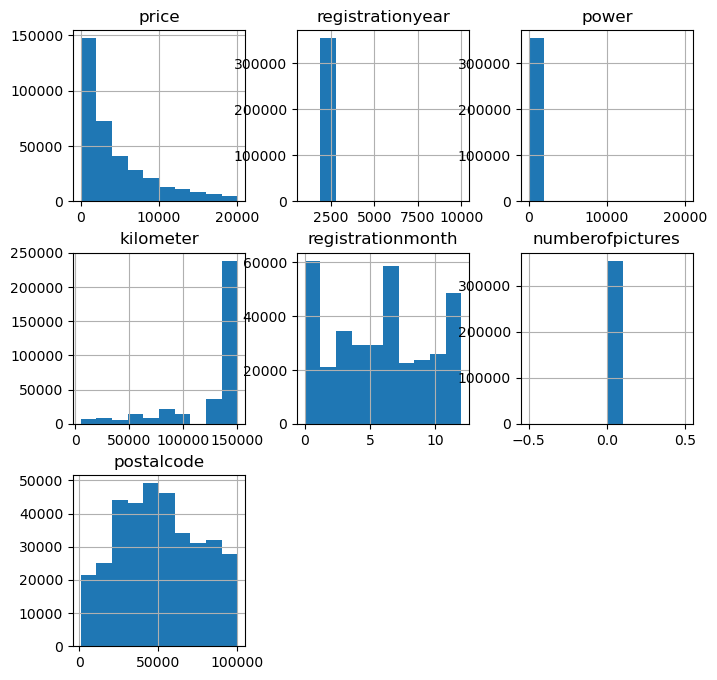

In [5]:
data.hist(figsize=(8,8))

Невооруженным взглядом видны выбросы как минимум в 3 признаках, необходимо будет внимательнее их изучить и обработать данные. Также для начала нам важно понять, какие признаки релевантны, а какие нет.

### Нерелевантные столбцы

Дата выгрузки точно никак не отностится к качеству модели. Также сомнения вызывает почтовый код. Для начала давайте посмотрим, какие у нас коды и я объясню ниже. 

In [6]:
print(data['postalcode'].value_counts())

10115    819
65428    613
66333    343
32257    317
44145    317
        ... 
91801      1
31097      1
82444      1
94359      1
31096      1
Name: postalcode, Length: 8143, dtype: int64


Первая мысль была через условный словрь сделать категориальный признак, который бы отражал города,но у нас в таблице 8143 почтовых кода... Сложно все сопоставить, разброс по городам, скорее всего, будет огромный. К тому же формат int, а значит, что все коды, которые начинаются с нуля - четрыехзначные вместо пяти. И нам над осначала исправить коды, потом создать справочник (по сути займет это очень долго, проще было бы купить, если бы был бюджет, на хорошую реальную модель 50-100 (а на оф сайте немецкой почты вообще 400) евро было бы не жалко, но только ради тренировочного проекта (и не факт, что у нас еще полноценыне данные т.е. есть вероятность еще больших осложнений) делать этого я не буду. Два дня собирать свой справочник тоже. 
К тому же есть еще одна сложность - мы будем делать модели в том числе, возможно, при помощи регрессии, а это значит, что придется кодировать с OHE. Если добавится 100-500 новых признаков на 350+ тысяч объектов мы тут все проклянем. 
Исходя из вышенаписанного мы все-таки отказываемся от признака "почтовый код" и параметр этот удалим. 

дату размещения объявления мы тоже удалим и на это есть как минимум 2 причины: 1) в гороскопы мы играть не будем 2) модель разрабатывается для новых объявлений, а это значит, что все объявления будут со свежей датой, следовательно я вообще не понимаю, что может дать нам разница в условных 3 месяца на обучающей выборке и как это повлияет на рассчитываемую цену автомобиля через 6 лет...

Также параметр "дата последней активности пользователя интересует нас еще меньше, если учитывать информацию выше. 

Однако у меня возникла интересная идея: зная дату размещения и дату регистрации автомобиля мы можем вычислить возраст автомобиля, который будет замечательным критерием, как мне кажется, как для дерева, так и для регрессии. Мне также кажется, этот параметр более универсален, в том числе, если применять его к более свежим данным. Но к этому мы вернемся немного позже. 

Это привет из будущего. Я решил вернуться в прошлое и исправить свои ошибки на раннем этапе - дропнуть все абсолютно бесполезные столбцы - и прямо сейчас. Ну совсем невозможно работать с данными. Каждый раз, когда выводим их на экран - получается абсолютно нечитаемые данные и вообще ни за что. 

также можно и пару названий колонок поменять для красоты и удобства

In [7]:
columns_to_drop = ['postalcode', 'lastseen', 'datecrawled']
data = data.drop(columns_to_drop, axis=1)

In [8]:
data = data.rename(columns = {'registrationyear':'regyear', 'registrationmonth':'regmonth',
                              'numberofpictures':'pictures'})
print(data)

        price  vehicletype  regyear gearbox  power        model  kilometer  \
0         480          NaN     1993  manual      0         golf     150000   
1       18300        coupe     2011  manual    190          NaN     125000   
2        9800          suv     2004    auto    163        grand     125000   
3        1500        small     2001  manual     75         golf     150000   
4        3600        small     2008  manual     69        fabia      90000   
...       ...          ...      ...     ...    ...          ...        ...   
354364      0          NaN     2005  manual      0         colt     150000   
354365   2200          NaN     2005     NaN      0          NaN      20000   
354366   1199  convertible     2000    auto    101       fortwo     125000   
354367   9200          bus     1996  manual    102  transporter     150000   
354368   3400        wagon     2002  manual    100         golf     150000   

        regmonth  fueltype           brand repaired          da

### Цена

Теперь давайте поищем пробелы и аномалии. 

изначально были видны аномалии по целевому параметру - цене. Похоже, очень много нулей.

In [9]:
print(data['price'].value_counts())

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: price, Length: 3731, dtype: int64


Данные, у которых не определено значение целевого параметра для нас абсолютно бесполезно, поскольку не несут ни обуччающей ни проверочной ценности.

In [10]:
data.shape

(354369, 13)

In [11]:
data = data.drop(data[data['price']==0].index)
data.shape

(343597, 13)

<Axes: >

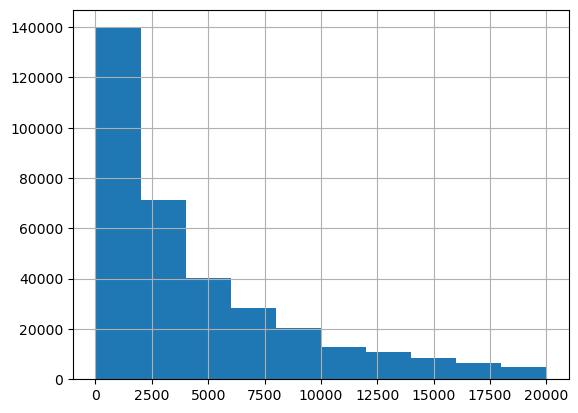

In [12]:
data['price'].hist()

In [13]:
print(data['price'].describe())

count    343597.000000
mean       4555.121974
std        4515.058553
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64


Теперь давайте на всякий случай также взглянем на  дешевые и дорогие машины:

In [14]:
print(data['price'].loc[data['price']<=100].value_counts())

1      1189
100    1031
50      327
80      146
99      109
10       84
70       69
60       58
30       55
75       54
20       51
40       45
90       41
25       33
15       27
5        26
55       20
65       19
35       18
45       16
95       13
2        12
49       12
85       11
8         9
3         8
9         8
12        8
13        7
39        6
59        6
11        5
17        5
14        5
79        4
18        3
7         3
89        3
69        3
19        3
66        2
16        2
98        2
29        2
33        1
24        1
4         1
88        1
47        1
38        1
21        1
32        1
58        1
27        1
26        1
74        1
77        1
Name: price, dtype: int64


Страшно, чему тут модель модет научиться.... что за машины такие за 1 евро? А за 4 евро? а за 12 евро? 

In [15]:
print(data.loc[data['price']==10])

        price  vehicletype  regyear gearbox  power        model  kilometer  \
20553      10        wagon     2006  manual      0       mondeo     150000   
22346      10          NaN     1995     NaN    102          NaN       5000   
23393      10        small     2002  manual      0       twingo     150000   
28305      10          NaN     1990     NaN      0  transporter      10000   
29438      10        wagon     2004     NaN      0        focus     150000   
...       ...          ...      ...     ...    ...          ...        ...   
338304     10        small     1998  manual      0           ka     150000   
343524     10          NaN     2000     NaN    170       vectra     150000   
348001     10  convertible     2000     NaN      0          NaN     125000   
349043     10        small     1999     NaN     75          NaN     150000   
349944     10          NaN     2005     NaN      0  transporter     150000   

        regmonth  fueltype           brand repaired          da

In [16]:
print(data.loc[data['price']==50])

        price vehicletype  regyear gearbox  power   model  kilometer  \
552        50         NaN     1985     NaN      0     NaN     150000   
5460       50       small     1994  manual     45   other     100000   
6209       50       wagon     2009     NaN      0  passat       5000   
8013       50       sedan     1993  manual    100      80     150000   
8777       50       small     1995  manual     45   corsa     150000   
...       ...         ...      ...     ...    ...     ...        ...   
344979     50       small     1997  manual      0      ka     150000   
347644     50       wagon     1994  manual     71   astra     150000   
351242     50         NaN     2016  manual      0   corsa     150000   
351768     50       wagon     2000     NaN      0     NaN     150000   
352221     50         NaN     1970     NaN      0     NaN       5000   

        regmonth fueltype           brand repaired          datecreated  \
552           11      NaN         trabant      NaN  2016-03-

In [17]:
print(data.loc[data['price']==19])

        price vehicletype  regyear gearbox  power        model  kilometer  \
99338      19         bus     1962     NaN     34  transporter     100000   
299828     19         NaN     1970     NaN      0          NaN     100000   
325202     19         NaN     1970     NaN      0  transporter     100000   

        regmonth fueltype       brand repaired          datecreated  pictures  
99338          1      NaN  volkswagen      NaN  2016-03-14 00:00:00         0  
299828         0      NaN  volkswagen      NaN  2016-04-04 00:00:00         0  
325202         1      NaN  volkswagen      NaN  2016-03-06 00:00:00         0  


In [18]:
print(data.loc[data['price']==100])

        price vehicletype  regyear gearbox  power     model  kilometer  \
964       100       wagon     1995  manual    116    passat     150000   
2139      100       small     1997  manual      0    twingo     150000   
2920      100         NaN     2018    auto    125  a_klasse     100000   
3833      100       sedan     1999  manual    130   primera     150000   
4177      100         NaN     2016  manual     39     swift     150000   
...       ...         ...      ...     ...    ...       ...        ...   
352961    100       small     1998  manual     60      polo     150000   
353660    100       wagon     1997  manual    101    vectra     150000   
353661    100       sedan     1998  manual     88   3_reihe     150000   
353669    100       small     1994  manual     60      polo     150000   
354018    100       small     1996  manual      0      polo     150000   

        regmonth fueltype          brand repaired          datecreated  \
964            9   petrol     volkswa

In [19]:
print(data.loc[data['price']==70])

        price vehicletype  regyear gearbox  power     model  kilometer  \
7629       70         NaN     2010     NaN      0  insignia       5000   
10216      70       other     1976     NaN      0    kaefer     150000   
10533      70         NaN     2016  manual      0    megane     150000   
16588      70       small     1997  manual     50     ibiza     150000   
27835      70       sedan     2014    auto      0  a_klasse      50000   
...       ...         ...      ...     ...    ...       ...        ...   
340320     70         NaN     2016     NaN      0     corsa     150000   
343087     70         NaN     2000     NaN      0       NaN     150000   
343983     70       small     1998  manual     60        ka     100000   
348813     70       small     1998  manual     80       NaN     150000   
353564     70         NaN     2000     NaN      0  e_klasse      10000   

        regmonth  fueltype          brand repaired          datecreated  \
7629           0       NaN          

В целом мне очень не нравятся данные по дешевым машинам. Во-первых, цены бредовые, во-вторых, там полно пропусков вообще во всех колонках и в третьих, нам, как мне кажется, важнее точно предсказывать более дорогие машины. Однако, если решим избавляться от каких-либо пропусков, то это в первую очередь отразится на супердешевых машинах. И все же давайте от машин дешевле 50 евро избавимся и не будем портить модель. 

In [20]:
data.shape

(343597, 13)

In [21]:
data = data.drop(data[data['price']<50].index)
data.shape

(341946, 13)

In [22]:
print(data.loc[data['price']>18000])

        price  vehicletype  regyear gearbox  power    model  kilometer  \
1       18300        coupe     2011  manual    190      NaN     125000   
172     19750  convertible     2006  manual    305  mustang      50000   
204     18400        wagon     2011    auto    313      5er     150000   
282     18700        coupe     2009    auto    213  mustang      80000   
337     18880          bus     2014  manual    116  5_reihe      20000   
...       ...          ...      ...     ...    ...      ...        ...   
353686  18429        sedan     2010  manual    272      3er     125000   
353927  18500        sedan     2009    auto    190      NaN     150000   
354045  20000        coupe     2006    auto    476    other     125000   
354178  19990        small     2014    auto    185       a1      10000   
354319  19800        sedan     2011  manual    170      1er      80000   

        regmonth  fueltype          brand repaired          datecreated  \
1              5  gasoline          

хорошие машины, думаю, тут ничего трогать не будем. Теперь перейдем к месяцу регистрации. 

### Месяц регистрации

In [23]:
print(data['regmonth'].value_counts())

3     33749
0     32067
6     30754
4     28627
5     28445
7     26607
10    25568
11    23719
12    23702
9     23326
1     22552
8     22077
2     20753
Name: regmonth, dtype: int64


13 месяцев это сильно)) Тем не менее, я не вижу, как лучше распределить данные с нуля, в любом случае это будет неточно, а удалять их, естественно, не хочется, поэтому оставим все как есть. Можем, конечно, также рассмотреть вариант с удалением этого параметра, но давайте проанализируем: обычно влияние имеет именно месяц производства машины, потому что произведена она может быть в январе, а зарегистрирована первым владельцем только в декабре. Тем не менее, думаю, есть некая корреляция между месяцем производства и месяцем регистрации. Также не исключаю, что под "месяцем регистрации" по факту может крыться месяц производства, т.к. мы не сильно осведомлены о порядке постановки на учет в Германии, поэтому параметр трогать мы пока не будем.

Но есть и агрумент против - для старых машин месяц производства куда менее важен, чем для новых. Условных полгода возраста для двухгодовалой и двадцатилетней машины это две огромны разницы. И если дерево может в теории это рассортировать, применяя параметр к одним значениям больше, чем к другим, то регрессия может научиться на более встарых данных и потом искажать прогнозы на более новых.

### Год регистрации

In [24]:
print(data['regyear'].value_counts())

2000    22818
1999    21897
2005    21404
2006    19650
2001    19592
        ...  
2200        1
8888        1
2290        1
9450        1
1946        1
Name: regyear, Length: 139, dtype: int64


In [25]:
print(data['regyear'].loc[(data['regyear']>2000) & (data['regyear']<2022)].value_counts())

2005    21404
2006    19650
2001    19592
2003    19458
2004    19305
2002    18680
2007    16986
2008    15235
2009    14378
2010    10667
2017     9841
2011     9816
2016     8899
2012     7109
2013     4083
2018     3766
2014     2498
2015     1177
2019       16
Name: regyear, dtype: int64


пропусков нет, а вот выбросы - пожалуйста. Хотя тут ничего неожиданного нет - мы по гистограмме уже все понимали, там еще где-то должно быть значение порядка 300. 88 уникальных значений - много. Давайте определим актуальный временной прмежуток: верхняя граница понятна - 2019 год, нижняя пускай будет 1970 год, чтобы уже не всех динозавров распугать)

In [26]:
data.shape

(341946, 13)

In [27]:
data = data.loc[(data['regyear']>1969) & (data['regyear']<2020)]
data.shape

(340735, 13)

<Axes: >

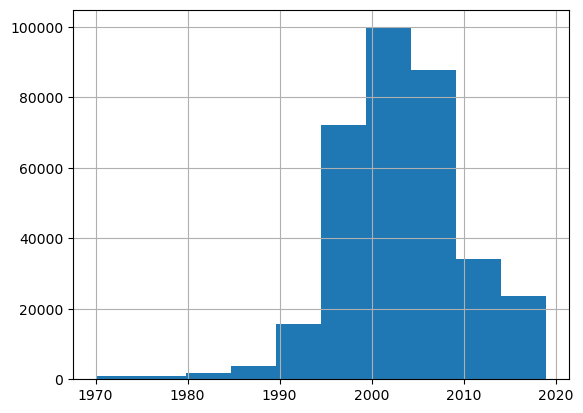

In [28]:
data['regyear'].hist()

<Axes: >

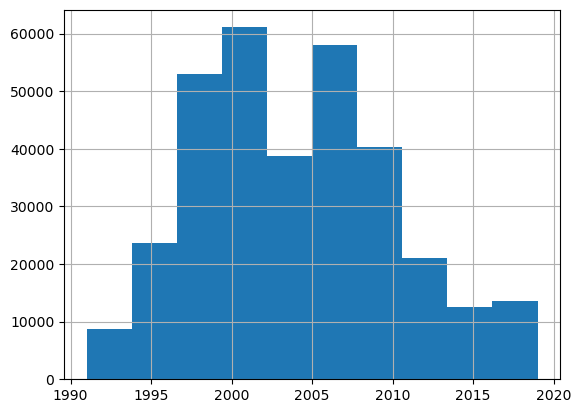

In [29]:
data['regyear'].loc[data['regyear']>1990].hist()

Вот а как бы еще мы увидели бимодальное распределение? А, может, был смысл до 1990 года все удалить? Может, и был, но значений там не так много и глобально картину они не испроотят, как мне кажется, зато, возможно дадут представление о цене древних машин. 

### Мощность

In [30]:
print(data['power'].value_counts())

0       35068
75      23212
60      15399
150     14101
101     12928
        ...  
1596        1
1240        1
1506        1
5809        1
1241        1
Name: power, Length: 691, dtype: int64


Изначально еще по гистограмме было понятно, что выбросы по мощности очень сильно портят общую картину. Давайте попробуем посмотреть на эти аномалии

In [31]:
print(data.loc[data['power']>500].head(20))

       price  vehicletype  regyear gearbox  power     model  kilometer  \
1816    3200        small     2004  manual   1398   corolla       5000   
4060    3100        sedan     2005  manual    953      colt     150000   
5328     500        wagon     1999  manual   1001     astra     150000   
6296     599        small     2002  manual    603     matiz       5000   
6504    3000        small     2009  manual    771     punto     125000   
6637     600        small     1996  manual    603     corsa     150000   
7661    1499        small     1999  manual   7515      lupo     150000   
7720    1500        small     2000  manual   1400       NaN     150000   
8057     500        small     2002  manual    620   ypsilon     150000   
9664    2599          NaN     2016  manual   1779    zafira     150000   
9875     550        wagon     2003  manual   1753     focus     150000   
12740   3500  convertible     2003  manual    952        ka      70000   
13373  18500        small     2002    

In [32]:
print(data['power'].loc[data['power']<30].value_counts())

0     35068
26      242
5        99
18       38
27       36
29       31
4        30
11       27
23       24
1        23
24       18
15       14
25       14
12       13
14       12
10       11
6        11
20       11
7        10
19       10
16        9
2         9
17        8
3         8
8         6
13        5
9         4
28        4
22        3
21        3
Name: power, dtype: int64


нули...40 000... 

Ошибки очевидны, суперкаров тут нет, но подозреваю, характер этих ошибок неоднороден и непредсказуем, где-то, по-видимому, забыли запятую, а где-то, похоже, вместо мощности внесли объем двигателя в кубических сантиметрах. А если брать ягуар с-тайп, то показатель мощности 600 - вообще загадка. Думаю, есть смысл от мощных выбросов избавиться, потому что они непредсказуемые и неисправляемые общим правилом. Что касается слабых машин, то нули мы по уберем, а потом посмотрим на оставшиеся слабые машины и, скорее всего, что-то еще уберем. 

Наверное, на этом этапе может появится вопрос, что же я за варвар такой, который столько данных удаляет? А все просто - заказчик хочет модель, которая предсказывает точно и качественно. И функционал приложения для нашей модели будет устроен так, что для получения оценки цены машины надо ввести все данные (предсказания с вилкой цены в рамках данного проекта мы делать не будем), тогда нам нет смысла учить модель на данных с пропусками. И если пропуски эти заолнить ничем адекватным у нас не получается, придется нам от этих данных избавляться.

In [33]:
data.shape

(340735, 13)

In [34]:
data = data.drop(data[data['power']==0].index)
data = data.drop(data[data['power']>500].index)
data.shape

(305256, 13)

In [35]:
print(data.loc[data['power']<30])

        price  vehicletype  regyear gearbox  power  model  kilometer  \
431      3950        small     2004    auto      5    NaN      70000   
1235     4450        small     1971  manual     23    500      70000   
1331      650          NaN     1970     NaN     26    NaN     100000   
3349     1990        small     2004     NaN      7   polo     150000   
3419     2300          NaN     2017  manual     26    601      70000   
...       ...          ...      ...     ...    ...    ...        ...   
349031   1000        sedan     1989  manual     26    601      80000   
349666   1500          NaN     2016     NaN      2    NaN     150000   
353127   8600  convertible     2012  manual      8    NaN       5000   
353501  11300        sedan     1988  manual     29  other     150000   
354360   3999        wagon     2005  manual      3    3er     150000   

        regmonth  fueltype           brand repaired          datecreated  \
431            5  gasoline  sonstige_autos       no  2016-0

Вот смотришь сомнительные данные и ожидаешь найти в них все что угодно, но не "ситроен 1988 года, не бит не крашен, 29 лошадиных сил, цена 4000 евро" и думаешь после этого, а мы точно имеем морально право на основе таких данных что-то строить? 

А вообще, если честно, не увидел я тут ни одной машины, которую можно было бы добавить в нашу модель и это было бы хорошо. 

In [36]:
data.shape

(305256, 13)

In [37]:
data = data.drop(data[data['power']<30].index)
data.shape

(304523, 13)

In [38]:
print(data.loc[data['power']>400].head(20))

       price  vehicletype  regyear gearbox  power     model  kilometer  \
2781   19500          suv     2004    auto    450   cayenne     125000   
3289   16899        wagon     2003    auto    476  e_klasse     150000   
4681   13900        sedan     2006    auto    476  e_klasse     150000   
5319   10999        wagon     2006    auto    435     other     150000   
10354  18900        wagon     2007    auto    420       3er     150000   
11613  17900        wagon     2000  manual    500     other     150000   
12104  18900        sedan     2006    auto    450     other     150000   
12267  17200        wagon     2006    auto    435        a6     150000   
13151  16000        sedan     2006    auto    450        a8     150000   
13766  18300          suv     2007    auto    426     grand     100000   
15689  15499        sedan     2005    auto    450        a8     150000   
17054   6000  convertible     2005    auto    500        sl      50000   
17228  14900        coupe     2006    

А вот здесь уже явной беды какой-то не заметно. хотя какая-то радость. 

<Axes: >

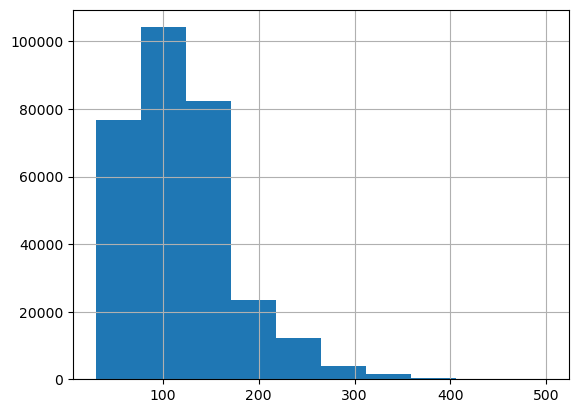

In [39]:
data['power'].hist()

Даже стало как-то похоже на график нормального распределения.

### Километраж

In [40]:
print(data['kilometer'].value_counts())

150000    203228
125000     32743
100000     13040
90000      10485
80000       9194
70000       7873
60000       6864
50000       5692
40000       4493
30000       3894
20000       3278
5000        2853
10000        886
Name: kilometer, dtype: int64


In [41]:
print(data.loc[data['kilometer'].isna()==True])

Empty DataFrame
Columns: [price, vehicletype, regyear, gearbox, power, model, kilometer, regmonth, fueltype, brand, repaired, datecreated, pictures]
Index: []


 Вот уж не ожидал, что такой важный параметр будет в порядке. Отличная новость! 

### Коробка передач

In [42]:
print(data['gearbox'].value_counts())

manual    238768
auto       59865
Name: gearbox, dtype: int64


In [43]:
print(data[data['gearbox'].isna()])

        price vehicletype  regyear gearbox  power  model  kilometer  regmonth  \
16        300         NaN     2016     NaN     60   polo     150000         0   
92        250         NaN     2000     NaN     60     ka     150000         0   
151      6799       small     2009     NaN     60    NaN      20000         5   
161      1495       wagon     2001     NaN     64    NaN     150000         9   
186     14000       sedan     2008     NaN    235    NaN     150000         0   
...       ...         ...      ...     ...    ...    ...        ...       ...   
353892   7900         bus     2009     NaN    140    NaN     125000         7   
354005    210       small     1997     NaN     60   polo     150000         0   
354133    250       small     1994     NaN     75   golf     150000         6   
354285   3500       small     2001     NaN     75  corsa      90000         4   
354329    350       small     1996     NaN     65  punto     150000         0   

        fueltype           

И где-то чуть меньше 6000 NAN. А изначально их было порядка 25 тысяч в этой категории! А значит, мы правильно все удаляем. Проопуски тут по своей сути плохо, поскольку Третьего тут не дано. Думаю, в данном случае можем попробовать использовать экспертное мнение. Скорее всего причина пропуска в том, что результат очевиден томуу, кто разбирается в машинах. А значит, можно посмотреть сколько-ниудь машин с пропусками вдруг, будет понятно, какая там коробка передач.

In [44]:
print(data[data['gearbox'].isna()==True])

        price vehicletype  regyear gearbox  power  model  kilometer  regmonth  \
16        300         NaN     2016     NaN     60   polo     150000         0   
92        250         NaN     2000     NaN     60     ka     150000         0   
151      6799       small     2009     NaN     60    NaN      20000         5   
161      1495       wagon     2001     NaN     64    NaN     150000         9   
186     14000       sedan     2008     NaN    235    NaN     150000         0   
...       ...         ...      ...     ...    ...    ...        ...       ...   
353892   7900         bus     2009     NaN    140    NaN     125000         7   
354005    210       small     1997     NaN     60   polo     150000         0   
354133    250       small     1994     NaN     75   golf     150000         6   
354285   3500       small     2001     NaN     75  corsa      90000         4   
354329    350       small     1996     NaN     65  punto     150000         0   

        fueltype           

Модель? - NA, была в ремонте? - NA, тип топлива? - NA, тип ТС - NA.... Нет уж, спасибо! - Пожалуйста! 

In [45]:
data.shape

(304523, 13)

In [46]:
data = data.dropna(subset=['gearbox'])
data.shape

(298633, 13)

In [47]:
data = data.reset_index(drop=True)

### Тип топлива

In [48]:
print(data['fueltype'].value_counts())

petrol      187052
gasoline     88145
lpg           4712
cng            492
hybrid         202
other           56
electric        36
Name: fueltype, dtype: int64


Бензин, дизель, пара видов газа, гибрид, электричество и прочее. Все культурно, только пропусков было много, насколько я помню. 

In [49]:
print(data.loc[data['fueltype'].isna()])

        price  vehicletype  regyear gearbox  power     model  kilometer  \
7         999        small     1998  manual    101      golf     150000   
11       2500        wagon     2004  manual    131    passat     150000   
22       5555          NaN     2017  manual    125        c4     125000   
31       1600        other     1991  manual     75    kadett      70000   
34       7500        sedan     2002    auto    306  e_klasse     150000   
...       ...          ...      ...     ...    ...       ...        ...   
298600   1300        small     1999  manual     75   2_reihe     125000   
298601   2999        wagon     2004  manual    234    vectra     100000   
298608   3850  convertible     2006  manual    108   2_reihe     125000   
298619   1900          NaN     2000  manual    110       NaN     150000   
298628   5250          NaN     2016    auto    150       159     150000   

        regmonth fueltype          brand repaired          datecreated  \
7              0      NaN

Опять пустоты... эти Наны друг к другу притягиваются. Ну как миниму коррелируют - тут и ремонтые пропуски и тип ТС и даже модель ТС. Любая модель авто может быть как бензиновой, так и дизельной, а некоторые даже гибридом. Тут мы пропуски запонить можем разве что заглушками. Но по факту мы уже это обсуждали выше и ничего на данный момент не поменялось. Да,17968 объектов - это много, а что делать? оставить 18000 объектов, которые испортят нам модель? 

In [50]:
data.shape

(298633, 13)

In [51]:
data = data.dropna(subset=['fueltype'])
data = data.reset_index(drop=True)
data.shape

(280695, 13)

### Модель

In [52]:
data['model'].value_counts()

golf                  23931
other                 19098
3er                   16673
polo                  10139
corsa                  9502
                      ...  
kalina                    5
samara                    4
rangerover                3
serie_3                   3
range_rover_evoque        2
Name: model, Length: 249, dtype: int64

In [53]:
print(data.loc[data['model'].isna()])

        price  vehicletype  regyear gearbox  power model  kilometer  regmonth  \
0       18300        coupe     2011  manual    190   NaN     125000         5   
141      1200        coupe     1990  manual     45   NaN     150000         0   
318     13950        other     2011  manual    140   NaN      60000        11   
334      5800          bus     2007  manual    105   NaN     150000        11   
456      3800  convertible     2005  manual    109   NaN     100000        12   
...       ...          ...      ...     ...    ...   ...        ...       ...   
280454   6000        small     2008  manual    155   NaN     150000         5   
280467    200        small     1998  manual     37   NaN     150000         4   
280591   5000        sedan     2002    auto    170   NaN     150000         0   
280600    560        small     2001    auto    170   NaN      90000         0   
280662   9400        wagon     2007  manual    200   NaN     150000         4   

        fueltype           

Опять же было 20 тысяч пропусков, а осталось чуть больше 8. Снова есть смежные пропуски. 

Модель - фундамент цены на автомобиль, если незаполнена модель, то чего мы, собственно, хотим? 

In [54]:
data.shape

(280695, 13)

In [55]:
data = data.dropna(subset = ['model']).reset_index(drop=True)
data.shape

(272470, 13)

### Тип ТС

In [56]:
print(data['vehicletype'].value_counts())

sedan          77043
small          63267
wagon          54946
bus            24637
convertible    17203
coupe          13173
suv            10006
other           1984
Name: vehicletype, dtype: int64


In [57]:
print(data.loc[data['vehicletype'].isna()])

        price vehicletype  regyear gearbox  power    model  kilometer  \
15       2900         NaN     2018  manual     90   meriva     150000   
23        899         NaN     2016  manual     60     clio     150000   
26        350         NaN     2016  manual     75     golf     150000   
35       7750         NaN     2017  manual     80     golf     100000   
38       2000         NaN     2017  manual     90    punto     150000   
...       ...         ...      ...     ...    ...      ...        ...   
272263   4900         NaN     2017  manual     69     polo     150000   
272264    600         NaN     2016  manual    170   vectra     150000   
272270    395         NaN     2016  manual     60     golf     150000   
272275   3600         NaN     2017  manual     86  transit     150000   
272278    299         NaN     2016  manual     60    astra     150000   

        regmonth  fueltype       brand repaired          datecreated  pictures  
15             5    petrol        opel    

Вначале было 40000 пропусков в типазх ТС, стало 10 000, данные становятся лучше. Возможно, придется с этими данными попрощаться, но пока не хочется. А что если бы мы смогли заполнить эти пропуски? Модели у нас есть, от всех пропусков в моделях мы избавились, а каждая модель практически всегда имеет определенный тип за исключением некоторых модификаций типа седан-купе, но это довольно редкий случай и предлагаю его в расчет не брать. Нам нужен код, который методом голосования сможет определить самый часто встречающийся тип ТС для каждой модели. Может, функция?  

In [58]:
type_by_model = data.groupby('model')['vehicletype'].apply(lambda x: x.value_counts().index[0])

print(type_by_model)

model
100              sedan
145              small
147              sedan
156              wagon
159              wagon
              ...     
yaris            small
yeti               suv
ypsilon          small
z_reihe    convertible
zafira             bus
Name: vehicletype, Length: 249, dtype: object


In [59]:
def fillna_row(row):
    if pd.isna(row['vehicletype']):
        return type_by_model[row['model']]
    else:
        return row['vehicletype']

In [60]:
data['vehicletype'] = data.apply(fillna_row, axis=1)

In [61]:
print(data['vehicletype'].value_counts())
print(data.loc[data['vehicletype'].isna()])

sedan          82089
small          66041
wagon          55853
bus            25859
convertible    17264
coupe          13269
suv            10109
other           1986
Name: vehicletype, dtype: int64
Empty DataFrame
Columns: [price, vehicletype, regyear, gearbox, power, model, kilometer, regmonth, fueltype, brand, repaired, datecreated, pictures]
Index: []


Значений в типах стало больше, проопусков стало ноль. Надеюсь, не зря старался.

### Фото

In [62]:
print(data['pictures'].value_counts())

0    272470
Name: pictures, dtype: int64


ха-ха! а я-то как-то и пропустил это на ггистограмме, хотя подзрения всю дорогу были. В таком случа параметр для нас бесполезен. 

In [63]:
data = data.drop('pictures', axis=1)

In [64]:
print(data)

        price  vehicletype  regyear gearbox  power        model  kilometer  \
0        9800          suv     2004    auto    163        grand     125000   
1        1500        small     2001  manual     75         golf     150000   
2        3600        small     2008  manual     69        fabia      90000   
3         650        sedan     1995  manual    102          3er     150000   
4        2200  convertible     2004  manual    109      2_reihe     150000   
...       ...          ...      ...     ...    ...          ...        ...   
272465   7900        sedan     2010  manual    140         golf     150000   
272466   3200        sedan     2004  manual    225         leon     150000   
272467   1199  convertible     2000    auto    101       fortwo     125000   
272468   9200          bus     1996  manual    102  transporter     150000   
272469   3400        wagon     2002  manual    100         golf     150000   

        regmonth  fueltype       brand repaired          datecr

### Определение возраста (и неожиданные проблемы)

Перед самым сложным моментом давайте сначала исполним задуманное - создадим колонку с возрастом машин и удалим дату создания заявки.

In [65]:
data['datecreated'] = pd.to_datetime(data['datecreated'], format = '%Y-%m-%d %H:%M:%S')
data['created'] = data['datecreated'].dt.year
print(data['created'].value_counts())
#ну да, почти все 2016 год, кто бы мог подумать. Стоп! А как тогда у нас в датасете машины моложе 2016 года?
# нужна срочная проверка!!!
#display(data)

2016    272447
2015        23
Name: created, dtype: int64


In [66]:
display(data.loc[data['regyear']==2018])

,price,vehicletype,regyear,gearbox,power,model,kilometer,regmonth,fueltype,brand,repaired,datecreated,created
15,2900,bus,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,2016
1707,1400,small,2018,manual,45,corsa,70000,12,petrol,opel,no,2016-03-27,2016
1739,5490,bus,2018,manual,110,transporter,150000,10,petrol,volkswagen,no,2016-03-21,2016
2114,8800,sedan,2018,manual,143,1er,150000,7,gasoline,bmw,no,2016-03-06,2016
2215,100,sedan,2018,auto,125,a_klasse,100000,0,petrol,mercedes_benz,yes,2016-03-05,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
271677,5399,bus,2018,manual,120,zafira,150000,10,gasoline,opel,no,2016-03-23,2016
271747,1100,sedan,2018,manual,75,civic,150000,0,petrol,honda,NaN,2016-03-07,2016
271859,4500,sedan,2018,manual,115,1er,150000,0,petrol,bmw,NaN,2016-04-02,2016
272048,3750,small,2018,manual,70,fiesta,125000,9,petrol,ford,NaN,2016-03-12,2016


тепреь и эти данные кажутся бредом.... и цена, и пробег

In [67]:
display(data.loc[data['regyear']==2016].head(30))

,price,vehicletype,regyear,gearbox,power,model,kilometer,regmonth,fueltype,brand,repaired,datecreated,created
23,899,small,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29,2016
26,350,sedan,2016,manual,75,golf,150000,4,petrol,volkswagen,no,2016-03-08,2016
57,150,sedan,2016,manual,75,astra,150000,3,petrol,opel,yes,2016-03-17,2016
129,3000,small,2016,auto,75,fabia,150000,0,petrol,skoda,NaN,2016-03-21,2016
144,1999,sedan,2016,manual,110,almera,150000,9,gasoline,nissan,NaN,2016-04-03,2016
209,150,small,2016,auto,75,fiesta,50000,1,petrol,ford,yes,2016-03-24,2016
274,1200,bus,2016,manual,75,modus,150000,0,petrol,renault,yes,2016-03-31,2016
417,4550,sedan,2016,manual,101,golf,150000,8,gasoline,volkswagen,no,2016-03-18,2016
491,1750,bus,2016,manual,116,galaxy,150000,3,gasoline,ford,yes,2016-03-16,2016
567,9000,sedan,2016,manual,122,1er,80000,12,petrol,bmw,no,2016-03-16,2016


А в 16м году машины 16го года с пробегом 150000 км за 150 евро... Ну это же откровенный мусор. Вот у нас на выходе мусор и получится, если так все оставить.

In [68]:
display(data.loc[data['regyear']==2015].head(30))

,price,vehicletype,regyear,gearbox,power,model,kilometer,regmonth,fueltype,brand,repaired,datecreated,created
128,16449,wagon,2015,auto,110,fabia,10000,8,petrol,skoda,no,2016-03-08,2016
419,11500,wagon,2015,auto,160,insignia,150000,5,gasoline,opel,no,2016-03-05,2016
541,13750,wagon,2015,manual,86,golf,20000,4,petrol,volkswagen,no,2016-03-10,2016
747,16999,small,2015,manual,102,one,10000,8,petrol,mini,no,2016-03-28,2016
1004,17900,convertible,2015,auto,84,fortwo,5000,5,petrol,smart,no,2016-03-20,2016
1469,10500,sedan,2015,manual,110,i_reihe,10000,11,gasoline,hyundai,no,2016-03-11,2016
1549,13790,small,2015,manual,90,fabia,20000,3,gasoline,skoda,no,2016-03-17,2016
2001,18900,bus,2015,manual,135,i_reihe,10000,2,petrol,hyundai,no,2016-03-06,2016
2196,11990,small,2015,manual,75,polo,10000,1,petrol,volkswagen,no,2016-03-26,2016
2257,13500,suv,2015,manual,105,yeti,10000,3,petrol,skoda,no,2016-03-09,2016


хотя бы 15й год в порядке и это невероятно радует! 

Мда, дальше уже и идти не хочется без серьезного разговора с тем, кто эти данные, нам предоставил. Данные действительно очень проблемные и при отсутствии какой-либо прочей информации о данных сложно верно оценить, каким данным точно можно верить, а каким нет.  И теперь, чтобы решить эти проблемы самостоятельно, приходится принимать целые цепочки сложных и, возможно, ошибочных решений. 

Вариантов у нас сейчас 3: 1)удалить колонки с датами и оставить все как есть, притвориься, что ничего такого мы не заметили - и будь что будет 2) Удалить все (а это на секундочку около 20 тысяч значений). Да плохо, но лучше, чем gigo! 3) Сделать свою оценку "экспертной" и на основе этой "экспертной" оценки сделать функцию и поменять значения года регистрации на тот, который я сочту правильным. А правильным я считаю допущение, что люди случайно единичку вместо нолика поставили в годе регистрации, потому что машины эти на десять лет выглядят вообще легко (можем, кстати, пару гистограмм по цене в 2006-2008 году сделать и увидим картин) как по цене, так и по пробегу.

<Axes: >

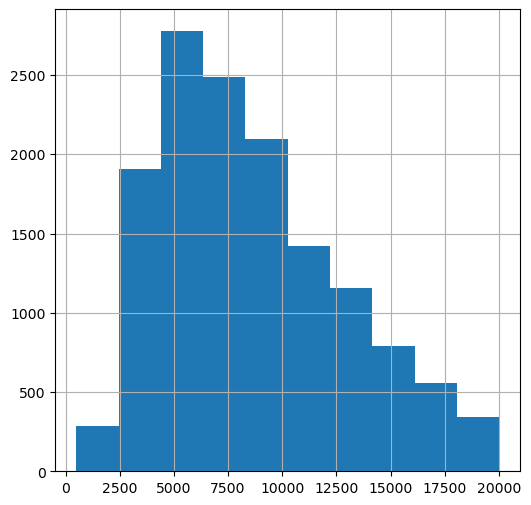

In [69]:
data['price'].loc[data['regyear']==2008].hist(figsize = [6,6])

<Axes: >

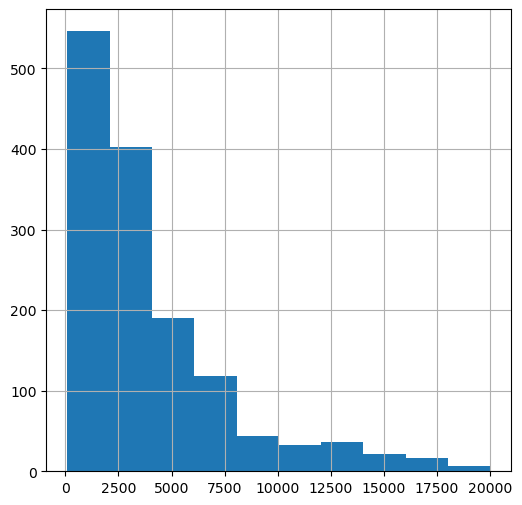

In [70]:
data['price'].loc[data['regyear']==2018].hist(figsize = [6,6])

<Axes: >

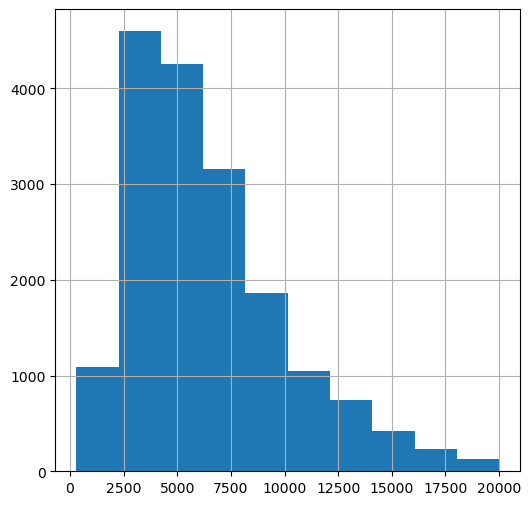

In [71]:
data['price'].loc[data['regyear']==2006].hist(figsize = [6,6])

Дешевых машин еще и больше в 2018 году, чем в 2008.

In [72]:
display(data.loc[(data['regyear']==2016) & (data['kilometer']<50000)].head(30))

,price,vehicletype,regyear,gearbox,power,model,kilometer,regmonth,fueltype,brand,repaired,datecreated,created
784,9200,sedan,2016,manual,75,golf,40000,8,petrol,volkswagen,no,2016-03-20,2016
911,17800,bus,2016,manual,99,other,5000,1,gasoline,peugeot,no,2016-04-03,2016
1505,10490,small,2016,manual,80,micra,5000,3,petrol,nissan,no,2016-03-19,2016
3928,1400,sedan,2016,manual,150,3er,20000,0,petrol,bmw,no,2016-04-04,2016
6152,1350,sedan,2016,manual,116,lancer,5000,2,petrol,mitsubishi,NaN,2016-03-28,2016
7712,16990,wagon,2016,auto,118,clio,5000,1,petrol,renault,no,2016-04-04,2016
9562,19950,wagon,2016,manual,120,focus,5000,1,gasoline,ford,no,2016-04-04,2016
9582,20000,sedan,2016,manual,110,a3,5000,0,petrol,audi,NaN,2016-03-23,2016
9740,7777,small,2016,auto,60,citigo,5000,3,petrol,skoda,no,2016-03-23,2016
10195,450,sedan,2016,manual,101,carisma,30000,12,petrol,mitsubishi,yes,2016-03-29,2016


В общем порядок такой: из года регистрации автомобилей младше 2016 года вычитаем 10 лет. Что касается авто 2016 года - то тут мы добавляем условия: пробег больше 50 000 км, цена меньше 2 000 евро, месяц регитрации позже месяца подачи объявления в любом из этих случаев тоже вычитаем 10 лет. Мы, конечно, можем что-то пропустить, но тем не менее это неплохлой фильтр. 10 лет были взяты из предположения, что поставлена единичка вместо нолика случано и также потому что подстановка нового года для этих машин выглядит сильно правдоподобнее, чем указанные годы регистрации.  

In [73]:
data['app_month'] = data['datecreated'].dt.month
print(data['app_month'].value_counts())

3     227792
4      44281
2        322
1         53
12         9
11         8
9          3
8          2
Name: app_month, dtype: int64


Кстати, любопытно, что в мае, июне, июле и октябре не было объявлений о продаже машин, а в апреле - подавляющее большинство заявлений. Ну как любопытно... Просто данные такие ***(кладет монетку в копилку за ругань)***

кстати, давайте сохранимся на этом моменте, пускай будет резервная копия. 

In [74]:
data_reserve_year = data.copy()

In [75]:
def correct_year(row):
    if row['regyear']>2016:
        return row['regyear']-10
    elif (row['regyear'] == 2016) & ((row['price']<2000) | (row['regmonth']>row['app_month']) | (row['kilometer']>50000)):
        return row['regyear']-10
    else:
        return row['regyear']

In [76]:
print(data['regyear'].value_counts())

2006    17541
1999    17485
2005    17290
2004    16735
2003    16696
2000    16209
2001    16196
2002    15798
2007    15198
2008    13822
1998    13380
2009    13216
1997    10931
2010     9896
2011     9239
1996     7975
2012     6654
1995     6021
2013     3827
2017     3761
1994     3586
2016     3152
1993     2513
2014     2308
1992     2225
1991     2050
1990     1474
2018     1414
2015     1006
1989      863
1988      666
1987      450
1985      361
1986      336
1983      291
1984      271
1982      217
1979      175
1980      171
1981      168
1978      156
1972      115
1977      107
1974       99
1973       95
1976       92
1971       83
1970       79
1975       70
2019        7
Name: regyear, dtype: int64


In [77]:
data['regyear'] = data.apply(correct_year, axis=1)

In [78]:
print(data['regyear'].value_counts())

2006    20566
2007    18959
1999    17485
2005    17290
2004    16735
2003    16696
2000    16209
2001    16196
2002    15798
2008    15236
1998    13380
2009    13223
1997    10931
2010     9896
2011     9239
1996     7975
2012     6654
1995     6021
2013     3827
1994     3586
1993     2513
2014     2308
1992     2225
1991     2050
1990     1474
2015     1006
1989      863
1988      666
1987      450
1985      361
1986      336
1983      291
1984      271
1982      217
1979      175
1980      171
1981      168
1978      156
2016      127
1972      115
1977      107
1974       99
1973       95
1976       92
1971       83
1970       79
1975       70
Name: regyear, dtype: int64


<Axes: >

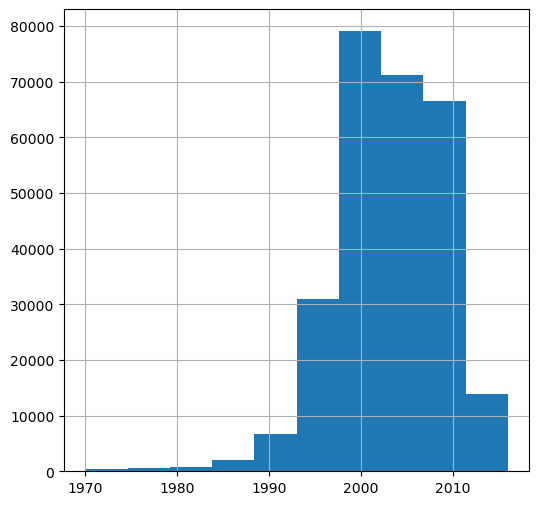

In [79]:
data['regyear'].hist(figsize=[6,6])

как бы получилось, но непонятно, надо радоваться или грустить... Ну и старые года немного портят график. Будет плохая модель - вернусь и все поудаляю! Я уже так пресытился этой предобработкой, что возиться с ней больше не буду. 

а теперь сделаем то, ради чего мы вообще за это взялись - создадим новый параметр - возраст машины.

In [80]:
data['age'] = data['created'] - data['regyear']
#display(data)

In [81]:
columns_to_drop = ['datecreated', 'created', 'app_month']
data = data.drop(columns_to_drop, axis=1)
display(data)

,price,vehicletype,regyear,gearbox,power,model,kilometer,regmonth,fueltype,brand,repaired,age
0,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,12
1,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,15
2,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,8
3,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,21
4,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,12
...,...,...,...,...,...,...,...,...,...,...,...,...
272465,7900,sedan,2010,manual,140,golf,150000,7,gasoline,volkswagen,no,6
272466,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,12
272467,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,16
272468,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,20


### Ремонт (и важное решение)

Теперь у нас на очереди ремонт, давайте им займемся и быстрее потом перейдем уже непосредственно к построению моделей.

In [82]:
print(data['repaired'].value_counts())
print(data.loc[data['repaired'].isna()])

no     212476
yes     25270
Name: repaired, dtype: int64
        price  vehicletype  regyear gearbox  power   model  kilometer  \
0        9800          suv     2004    auto    163   grand     125000   
5       14500          bus     2014  manual    125   c_max      30000   
8         999        wagon     1995  manual    115  passat     150000   
23        899        small     2006  manual     60    clio     150000   
29      12500        sedan     2006    auto    231     5er     150000   
...       ...          ...      ...     ...    ...     ...        ...   
272449    699        sedan     1999  manual    101  vectra     150000   
272456   5999        wagon     2005  manual    140      a4     150000   
272462    999  convertible     2000  manual     95  megane     150000   
272463   1690        wagon     2004  manual     55   fabia     150000   
272469   3400        wagon     2002  manual    100    golf     150000   

        regmonth  fueltype       brand repaired  age  
0          

35000 пропусков... не хотелось бы еще и их удалять... хотя бы потому, что все остальные параметры у этих данных уже обработаны. Пропусков у нас, кстати больше, чем машин, находившихся в ремонте - есть над чем подумать. Можно попробовать соотнести этот параметр с каким-нибудь другим, например, с возрастом (что хотя бы отчасти логично) и что-нибудь выяснить.

In [83]:
data1 = data.copy()

In [84]:
data1['repaired'] = data1['repaired'].fillna(value='?')
#display(data1)

In [85]:
d1_pivot = data1.pivot_table(index='regyear', columns='repaired', values='gearbox', aggfunc='count')

In [86]:
print(d1_pivot)

repaired     ?     no   yes
regyear                    
1970        20     51     8
1971        12     63     8
1972        15     90    10
1973        15     72     8
1974        13     82     4
1975        17     48     5
1976        13     68    11
1977        20     76    11
1978        23    125     8
1979        23    137    15
1980        35    119    17
1981        29    125    14
1982        34    166    17
1983        49    218    24
1984        47    190    34
1985        90    238    33
1986        50    244    42
1987        88    309    53
1988       134    479    53
1989       139    603   121
1990       313    992   169
1991       353   1453   244
1992       369   1557   299
1993       466   1712   335
1994       674   2397   515
1995      1234   3900   887
1996      1559   5322  1094
1997      2056   7217  1658
1998      2282   9200  1898
1999      2701  12459  2325
2000      2533  11612  2064
2001      2145  12187  1864
2002      1971  12247  1580
2003      1926  1319

In [87]:
d1_pivot2 = data1.pivot_table(index='kilometer', columns='repaired', values='gearbox', aggfunc='count')

In [88]:
print(d1_pivot2)

repaired       ?      no    yes
kilometer                      
5000         598    1276    235
10000         49     743     35
20000        242    2527    169
30000        232    3212    165
40000        255    3835    143
50000        328    4798    217
60000        422    5768    254
70000        581    6440    315
80000        648    7431    433
90000        829    8297    590
100000      1077   10105    778
125000      3044   24587   2153
150000     26419  133457  19783


Печальная правда в том, что как ты ни глянь, невозможно точно определить. 

И вот стоим мы теперь на распутье как Илья Иуромец: 1)удалишь 12% во всем остальном хороших данных - модель подпортишь 2)заглушку поставишь - и lighrgbm, на древеной базе построенный, бесполезных тебе ветвей понаделает 3)а коли по моде пропуски заполнишь ('нет' то бишь), параметр исковеркашь, хоть целостность данных сохранишь. 

Наименьшим из зол кажется заполнение параметра по моде. Однако заполнить и просто забыть мы не можем - это слишком большое изменение. И тут, мне кажется, пора дублировать наш датасет. В одной копии мы заполним пустоты по моде, а другую оставим, чтобы потом все бездушно удалить, если что. Работать мы изначально будем с первым датасетом, но в случае возникновения проблем с качеством предсказаний сможем вернуться ко второму варианту.

In [89]:
data_repair = data.copy()

In [90]:
data['repaired'].fillna(value='no', inplace=True)

In [91]:
display(data)
print(data['repaired'].value_counts())

,price,vehicletype,regyear,gearbox,power,model,kilometer,regmonth,fueltype,brand,repaired,age
0,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,12
1,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,15
2,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,8
3,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,21
4,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,12
...,...,...,...,...,...,...,...,...,...,...,...,...
272465,7900,sedan,2010,manual,140,golf,150000,7,gasoline,volkswagen,no,6
272466,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,12
272467,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,16
272468,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,20


no     247200
yes     25270
Name: repaired, dtype: int64


Если подводить небольшой итог то, отметим, что данные сами по себе были ужасно кривые, с огромным количеством пропусков, неточностей и ошибок. мы исправили то, что смогли так, как смогли. Надеюсь, не придется сюда возвращаться и все что-то переделывать, но тем не менее у нас есть резервные копии и есть понимание, что в теории может негативно влиять на резулттаты предсказаний. 

## Обучение моделей

Теперь давайте обучим 3 модели и протестируем их. Думаю, есть смысл построить модель регрессии, модель случайного леса и бустинг lightgbm. Потом сравним их скорость обучения, скорость предсказания и качество. Метрикой оценки качества будет rmse. Отдельно хочу отметить, что для каждого типа модели у нас будет отдельное кодирование: ohe для регресси, ordinal для леса,  а для бустинга мы ничего делаьть не будем, в теории там уже зашит CatBoostEncoding. Опять же в теории при некоторых условиях (например, слишком много категорий в моделях автомобилей) Catboost encoding может работать хуже, чем ordinal и это мы тоже попробуем выяснить.

### Модель регрессии

In [92]:
data_ohe = data.copy()
data_ohe = pd.get_dummies(data, drop_first=True)

In [93]:
data_ohe.shape

(272470, 307)

In [94]:
display(data_ohe)

,price,regyear,power,kilometer,regmonth,age,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,...,brand_seat,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_yes
0,9800,2004,163,125000,8,12,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1500,2001,75,150000,6,15,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3600,2008,69,90000,7,8,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,650,1995,102,150000,10,21,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,2200,2004,109,150000,8,12,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272465,7900,2010,140,150000,7,6,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
272466,3200,2004,225,150000,5,12,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
272467,1199,2000,101,125000,3,16,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
272468,9200,1996,102,150000,3,20,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [95]:
target = data_ohe['price']
features = data_ohe.drop(['price'] , axis=1)
print(target.shape)
print(features.shape)

(272470,)
(272470, 306)


In [96]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345)

In [97]:
print(features_train.shape)
print(features_valid.shape)
print(target_train.shape)
print(target_valid.shape)

(153264, 306)
(51088, 306)
(153264,)
(51088,)


In [98]:
%%time
regression = LinearRegression()
regression.fit(features_train, target_train)

CPU times: user 20.8 s, sys: 2.41 s, total: 23.2 s
Wall time: 4.83 s


LinearRegression()

In [99]:
%%time
print(mean_squared_error(target_valid, regression.predict(features_valid))**0.5)

2474.1788272883327
CPU times: user 402 ms, sys: 343 ms, total: 745 ms
Wall time: 116 ms


ЕЕЕЕ бой! Регрессия сама по себе уже дала приемимый для заказчика результат на валидационной выборке. Мне кажется, это очень круто! И скорость тоже супер, что неудивительно для модели регрессии. Значит, скорее всего, предобработка была проведена отлично.

### Случайный лес

In [100]:
target2 = data['price']
features2 = data.drop(['price'] , axis=1)
print(target2.shape)
print(features2.shape)

(272470,)
(272470, 11)


In [101]:
features_train2, features_test2, target_train2, target_test2 = train_test_split(
    features2, target2, test_size=0.25, random_state=12345)
features_train2, features_valid2, target_train2, target_valid2 = train_test_split(
    features_train2, target_train2, test_size=0.25, random_state=12345)

In [106]:
cols = ['vehicletype', 'gearbox', 'model', 'regmonth', 'fueltype', 'brand', 'repaired']

In [107]:
encoder = OrdinalEncoder()
encoder.fit(features_train2[cols])
features_train2[cols] = encoder.transform(features_train2[cols])
display(features_train2)

,vehicletype,regyear,gearbox,power,model,kilometer,regmonth,fueltype,brand,repaired,age
231556,5.0,2000,1.0,60,8.0,150000,5.0,6.0,25.0,1.0,16
185985,5.0,1993,1.0,60,116.0,150000,9.0,6.0,37.0,0.0,23
15125,7.0,2005,1.0,102,163.0,150000,5.0,6.0,31.0,0.0,11
157947,0.0,2009,1.0,105,221.0,150000,1.0,2.0,37.0,0.0,7
267700,2.0,1995,1.0,139,166.0,150000,12.0,6.0,9.0,0.0,21
...,...,...,...,...,...,...,...,...,...,...,...
1895,5.0,1998,1.0,60,8.0,100000,11.0,6.0,25.0,0.0,18
236269,7.0,2007,1.0,115,170.0,150000,1.0,6.0,37.0,0.0,9
254949,1.0,2005,0.0,163,207.0,125000,1.0,6.0,20.0,0.0,11
270134,2.0,1998,0.0,110,116.0,150000,7.0,2.0,37.0,0.0,18


In [108]:
features_valid2[cols] = encoder.transform(features_valid2[cols])

In [109]:
best_rfr = None
best_result = 99999999
best_est = 0
best_depth = 0

In [110]:
%%time
for est in range(1, 51, 5):
    for depth in range(1,13):
        rfr = RandomForestRegressor(random_state=1984, n_estimators=est, max_depth=depth)
        rfr.fit(features_train2, target_train2)
        result = mean_squared_error(target_valid2, rfr.predict(features_valid2))**0.5
        if result < best_result:
            best_rfr = rfr
            best_result = result
            best_est = est
            best_depth = depth
print("RMSE наилучшей модели на валидационной выборке:", 
      best_result, "Количество деревьев:", best_est, "Глубина:", best_depth)

RMSE наилучшей модели на валидационной выборке: 1748.5980310979598 Количество деревьев: 46 Глубина: 12
CPU times: user 8min 34s, sys: 3.66 s, total: 8min 38s
Wall time: 8min 45s


In [111]:
%%time
rfr2 = RandomForestRegressor(random_state=1984, n_estimators=46, max_depth=11)
rfr2.fit(features_train2, target_train2)

CPU times: user 13.3 s, sys: 116 ms, total: 13.4 s
Wall time: 13.7 s


RandomForestRegressor(max_depth=11, n_estimators=46, random_state=1984)

Да, относительно долго считает, но rmse 1810 евро на валидационной выборке, что ощутимо меньше, чем у регрессии. Ну и чтобы отдельно посчитать скорость предсказания, давай это сделаем в отдельной ячейке

In [112]:
%%time
print(mean_squared_error(target_valid2, rfr2.predict(features_valid2))**0.5)

1810.1906463691469
CPU times: user 275 ms, sys: 3.3 ms, total: 278 ms
Wall time: 278 ms


зато предсказания считает моментально))

Отдельно хочу оговориться, что gridsearch мы не используем, поскольку согласно заданию модель должна обучаться быстро, а на таком объеме данных у gridsearch это займет порядка часа-двух, так что эту возможность мы исключили заранее. 

### Модель LightGBM

In [113]:
target3 = data['price']
features3 = data.drop(['price'] , axis=1)

In [114]:
categorical_cols = ['vehicletype', 'gearbox', 'model', 'regmonth', 'fueltype', 'brand', 'repaired']
#cols = ['vehicletype', 'gearbox', 'model', 'regmonth', 'fueltype', 'brand', 'repaired']
#categorical_cols = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired']

In [115]:
for col in categorical_cols:
    features3[col] = pd.Categorical(features3[col])

In [116]:
features_train3, features_test3, target_train3, target_test3 = train_test_split(
    features3, target3, test_size=0.25, random_state=12345)
features_train3, features_valid3, target_train3, target_valid3 = train_test_split(
    features_train3, target_train3, test_size=0.25, random_state=12345)
print(features_train3.shape)
print(features_valid3.shape)
print(target_train3.shape)
print(target_valid3.shape)

(153264, 11)
(51088, 11)
(153264,)
(51088,)


In [118]:
display(features_train3)

,vehicletype,regyear,gearbox,power,model,kilometer,regmonth,fueltype,brand,repaired,age
231556,small,2000,manual,60,2_reihe,150000,5,petrol,peugeot,yes,16
185985,small,1993,manual,60,golf,150000,9,petrol,volkswagen,no,23
15125,wagon,2005,manual,102,octavia,150000,5,petrol,skoda,no,11
157947,bus,2009,manual,105,touran,150000,1,gasoline,volkswagen,no,7
267700,coupe,1995,manual,139,other,150000,12,petrol,fiat,no,21
...,...,...,...,...,...,...,...,...,...,...,...
1895,small,1998,manual,60,2_reihe,100000,11,petrol,peugeot,no,18
236269,wagon,2007,manual,115,passat,150000,1,petrol,volkswagen,no,9
254949,convertible,2005,auto,163,slk,125000,1,petrol,mercedes_benz,no,11
270134,coupe,1998,auto,110,golf,150000,7,gasoline,volkswagen,no,18


In [119]:
print(features_train3.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153264 entries, 231556 to 18421
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   vehicletype  153264 non-null  category
 1   regyear      153264 non-null  int64   
 2   gearbox      153264 non-null  category
 3   power        153264 non-null  int64   
 4   model        153264 non-null  category
 5   kilometer    153264 non-null  int64   
 6   regmonth     153264 non-null  category
 7   fueltype     153264 non-null  category
 8   brand        153264 non-null  category
 9   repaired     153264 non-null  category
 10  age          153264 non-null  int64   
dtypes: category(7), int64(4)
memory usage: 7.0 MB
None


In [124]:
categorical_features = [0, 1, 2, 4, 6, 7, 8, 9]

In [125]:
train_data = lgb.Dataset(features_train3, label=target_train3, categorical_feature=categorical_features, free_raw_data=False)
valid_data = lgb.Dataset(features_valid3, label=target_valid3, categorical_feature=categorical_features, free_raw_data=False)
test_data = lgb.Dataset(features_test3, label=target_test3, categorical_feature=categorical_features, free_raw_data=False)

In [126]:
#print(train_data)

In [127]:
%%time
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,    
    'bagging_freq': 5,          
    'verbose': -1,              
    'n_jobs': -1               
}

lgbm_model1 = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[train_data, valid_data], early_stopping_rounds=100)

/Users/BrightFuture/opt/anaconda3/envs/word2vec_env/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/BrightFuture/opt/anaconda3/envs/word2vec_env/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/BrightFuture/opt/anaconda3/envs/word2vec_env/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/BrightFuture/opt/anaconda3/envs/word2vec_env/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is

[1]	training's rmse: 4457.3	valid_1's rmse: 4490.61
Training until validation scores don't improve for 100 rounds
[2]	training's rmse: 4292.14	valid_1's rmse: 4324.67
[3]	training's rmse: 4137.27	valid_1's rmse: 4169.19
[4]	training's rmse: 3989.93	valid_1's rmse: 4020.92
[5]	training's rmse: 3852.88	valid_1's rmse: 3883.11
[6]	training's rmse: 3723.97	valid_1's rmse: 3753.77
[7]	training's rmse: 3601.27	valid_1's rmse: 3630.29
[8]	training's rmse: 3485.45	valid_1's rmse: 3513.42
[9]	training's rmse: 3377.91	valid_1's rmse: 3405.54
[10]	training's rmse: 3274.68	valid_1's rmse: 3302
[11]	training's rmse: 3181.11	valid_1's rmse: 3208.27
[12]	training's rmse: 3090.9	valid_1's rmse: 3117.51
[13]	training's rmse: 3005.75	valid_1's rmse: 3032.02
[14]	training's rmse: 2926.41	valid_1's rmse: 2952.25
[15]	training's rmse: 2851.68	valid_1's rmse: 2877.21
[16]	training's rmse: 2782.95	valid_1's rmse: 2808.44
[17]	training's rmse: 2716.66	valid_1's rmse: 2741.9
[18]	training's rmse: 2653.06	valid

[165]	training's rmse: 1564.09	valid_1's rmse: 1628.38
[166]	training's rmse: 1563.57	valid_1's rmse: 1628.16
[167]	training's rmse: 1563.11	valid_1's rmse: 1627.82
[168]	training's rmse: 1562.24	valid_1's rmse: 1627.29
[169]	training's rmse: 1561.7	valid_1's rmse: 1626.97
[170]	training's rmse: 1561	valid_1's rmse: 1626.56
[171]	training's rmse: 1560.48	valid_1's rmse: 1626.22
[172]	training's rmse: 1559.95	valid_1's rmse: 1625.85
[173]	training's rmse: 1559.49	valid_1's rmse: 1625.65
[174]	training's rmse: 1559.06	valid_1's rmse: 1625.43
[175]	training's rmse: 1558.26	valid_1's rmse: 1624.92
[176]	training's rmse: 1557.8	valid_1's rmse: 1624.64
[177]	training's rmse: 1557.09	valid_1's rmse: 1624.21
[178]	training's rmse: 1556.53	valid_1's rmse: 1623.82
[179]	training's rmse: 1555.98	valid_1's rmse: 1623.54
[180]	training's rmse: 1555.41	valid_1's rmse: 1623.04
[181]	training's rmse: 1554.79	valid_1's rmse: 1622.72
[182]	training's rmse: 1554.12	valid_1's rmse: 1622.33
[183]	training'

[341]	training's rmse: 1492.57	valid_1's rmse: 1592.85
[342]	training's rmse: 1492.26	valid_1's rmse: 1592.73
[343]	training's rmse: 1491.98	valid_1's rmse: 1592.54
[344]	training's rmse: 1491.48	valid_1's rmse: 1592.16
[345]	training's rmse: 1491.26	valid_1's rmse: 1592.07
[346]	training's rmse: 1491.01	valid_1's rmse: 1592.05
[347]	training's rmse: 1490.64	valid_1's rmse: 1591.84
[348]	training's rmse: 1490.37	valid_1's rmse: 1591.79
[349]	training's rmse: 1490.16	valid_1's rmse: 1591.62
[350]	training's rmse: 1489.97	valid_1's rmse: 1591.57
[351]	training's rmse: 1489.49	valid_1's rmse: 1591.28
[352]	training's rmse: 1489.06	valid_1's rmse: 1590.96
[353]	training's rmse: 1488.76	valid_1's rmse: 1590.82
[354]	training's rmse: 1488.51	valid_1's rmse: 1590.75
[355]	training's rmse: 1488.27	valid_1's rmse: 1590.7
[356]	training's rmse: 1488	valid_1's rmse: 1590.57
[357]	training's rmse: 1487.73	valid_1's rmse: 1590.42
[358]	training's rmse: 1487.36	valid_1's rmse: 1590.19
[359]	training

[520]	training's rmse: 1449.73	valid_1's rmse: 1576.95
[521]	training's rmse: 1449.54	valid_1's rmse: 1576.91
[522]	training's rmse: 1449.35	valid_1's rmse: 1576.92
[523]	training's rmse: 1449.18	valid_1's rmse: 1576.92
[524]	training's rmse: 1448.97	valid_1's rmse: 1576.86
[525]	training's rmse: 1448.85	valid_1's rmse: 1576.78
[526]	training's rmse: 1448.66	valid_1's rmse: 1576.71
[527]	training's rmse: 1448.43	valid_1's rmse: 1576.57
[528]	training's rmse: 1448.26	valid_1's rmse: 1576.47
[529]	training's rmse: 1448.11	valid_1's rmse: 1576.48
[530]	training's rmse: 1447.91	valid_1's rmse: 1576.39
[531]	training's rmse: 1447.75	valid_1's rmse: 1576.32
[532]	training's rmse: 1447.56	valid_1's rmse: 1576.27
[533]	training's rmse: 1447.38	valid_1's rmse: 1576.27
[534]	training's rmse: 1447.25	valid_1's rmse: 1576.24
[535]	training's rmse: 1447.11	valid_1's rmse: 1576.23
[536]	training's rmse: 1446.87	valid_1's rmse: 1576.06
[537]	training's rmse: 1446.72	valid_1's rmse: 1575.97
[538]	trai

[706]	training's rmse: 1416.23	valid_1's rmse: 1567.55
[707]	training's rmse: 1416.13	valid_1's rmse: 1567.53
[708]	training's rmse: 1415.95	valid_1's rmse: 1567.5
[709]	training's rmse: 1415.85	valid_1's rmse: 1567.46
[710]	training's rmse: 1415.76	valid_1's rmse: 1567.46
[711]	training's rmse: 1415.64	valid_1's rmse: 1567.51
[712]	training's rmse: 1415.48	valid_1's rmse: 1567.51
[713]	training's rmse: 1415.37	valid_1's rmse: 1567.51
[714]	training's rmse: 1415.27	valid_1's rmse: 1567.55
[715]	training's rmse: 1415.02	valid_1's rmse: 1567.36
[716]	training's rmse: 1414.81	valid_1's rmse: 1567.29
[717]	training's rmse: 1414.43	valid_1's rmse: 1567.11
[718]	training's rmse: 1414.27	valid_1's rmse: 1567.07
[719]	training's rmse: 1414.12	valid_1's rmse: 1567.07
[720]	training's rmse: 1413.95	valid_1's rmse: 1567.08
[721]	training's rmse: 1413.83	valid_1's rmse: 1567.03
[722]	training's rmse: 1413.72	valid_1's rmse: 1567.04
[723]	training's rmse: 1413.6	valid_1's rmse: 1567.05
[724]	traini

[883]	training's rmse: 1391.3	valid_1's rmse: 1562.98
[884]	training's rmse: 1391.2	valid_1's rmse: 1562.92
[885]	training's rmse: 1391.08	valid_1's rmse: 1562.87
[886]	training's rmse: 1390.93	valid_1's rmse: 1562.82
[887]	training's rmse: 1390.78	valid_1's rmse: 1562.78
[888]	training's rmse: 1390.47	valid_1's rmse: 1562.66
[889]	training's rmse: 1390.35	valid_1's rmse: 1562.66
[890]	training's rmse: 1390.19	valid_1's rmse: 1562.65
[891]	training's rmse: 1390.05	valid_1's rmse: 1562.64
[892]	training's rmse: 1389.85	valid_1's rmse: 1562.56
[893]	training's rmse: 1389.67	valid_1's rmse: 1562.51
[894]	training's rmse: 1389.51	valid_1's rmse: 1562.5
[895]	training's rmse: 1389.38	valid_1's rmse: 1562.53
[896]	training's rmse: 1389.18	valid_1's rmse: 1562.38
[897]	training's rmse: 1388.93	valid_1's rmse: 1562.28
[898]	training's rmse: 1388.72	valid_1's rmse: 1562.24
[899]	training's rmse: 1388.63	valid_1's rmse: 1562.24
[900]	training's rmse: 1388.51	valid_1's rmse: 1562.23
[901]	trainin

LightGBM оказался действительно быстрее и качественне. И с завидным постоянством выдает все тот же результат по качеству, хотя скорость сильно варьируется : в прошлый раз было 17 минут, в этот раз 1 минута. Вот и сравним давайте:

[1000]	training's rmse: 1374.7	valid_1's rmse: 1558.92
CPU times: user 16min 37s, sys: 8.11 s, total: 16min 45s
Wall time: 16min 56s

[1000]	training's rmse: 1374.7	valid_1's rmse: 1558.92
CPU times: user 55.4 s, sys: 294 ms, total: 55.7 s
Wall time: 57.1 s

А в очередной раз уже 15 минут... Похоже, это все же ближе к истине... а потом опять минута....

In [128]:
%%time
print(mean_squared_error(target_valid3, lgbm_model1.predict(features_valid3))**0.5)

1558.9181147045379
CPU times: user 5.57 s, sys: 138 ms, total: 5.71 s
Wall time: 885 ms


Но давайте сделаем еще 2 попытки - попробуем то же самое, но немного поменяем гиперпараметры в первом случае. А во втором случае еще и возьмем данные из порядкового кодирования, которое мы делали для случайного леса. Как я уже упоминал, обучение по ним может оказаться эффективнее. 

In [129]:
params2 = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 10,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'n_jobs': -1
}

In [130]:
#%%time
#lgbm_model2 = lgb.train(params2, train_data, num_boost_round=2000, valid_sets=[train_data, valid_data], early_stopping_rounds=100)

Обучается модель почти с той же скоростью. По качеству она незначительно уступает нашей первой бустинговой модели! Больше итераций, но каждое деревце по-проще.

2000]	training's rmse: 1400.42	valid_1's rmse: 1584.09
CPU times: user 1min 11s, sys: 320 ms, total: 1min 11s
Wall time: 1min 13s

In [131]:
#%%time
#print(mean_squared_error(target_valid3, lgbm_model2.predict(features_valid3))**0.5)

In [132]:
print(features_train2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153264 entries, 231556 to 18421
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   vehicletype  153264 non-null  float64
 1   regyear      153264 non-null  int64  
 2   gearbox      153264 non-null  float64
 3   power        153264 non-null  int64  
 4   model        153264 non-null  float64
 5   kilometer    153264 non-null  int64  
 6   regmonth     153264 non-null  float64
 7   fueltype     153264 non-null  float64
 8   brand        153264 non-null  float64
 9   repaired     153264 non-null  float64
 10  age          153264 non-null  int64  
dtypes: float64(7), int64(4)
memory usage: 14.0 MB
None


In [133]:
train_data2 = lgb.Dataset(features_train2, label=target_train2, categorical_feature=categorical_features, free_raw_data=False)
valid_data2 = lgb.Dataset(features_valid2, label=target_valid2, categorical_feature=categorical_features, free_raw_data=False)
test_data2 = lgb.Dataset(features_test2, label=target_test2, categorical_feature=categorical_features, free_raw_data=False)

In [134]:
#%%time
#lgbm_model3 = lgb.train(params2, train_data2, num_boost_round=2000, valid_sets=[train_data2, valid_data2], early_stopping_rounds=100)

[2000]	training's rmse: 1400.42	valid_1's rmse: 1584.06
CPU times: user 1min 17s, sys: 387 ms, total: 1min 17s
Wall time: 1min 19s

In [135]:
#%%time
#print(mean_squared_error(target_valid2, lgbm_model3.predict(features_valid2))**0.5)

## Анализ моделей

Итак, мы постоили 3 модели - регрессии, случайного леса и градиентного бустинга. Давайте сравним их и выберем одну для тестирования.

In [136]:
anal = [['regression', 0.28, 2474, 0.4],
        ['forest', 0.25, 1810, 0.3],
        ['boosting', 0.95, 1558, 10.8]]

cols = ['model', 'train_time_mins', 'rmse_eur', 'prediction_time_sec']
analysys = pd.DataFrame(anal, columns=cols)
print(analysys)

        model  train_time_mins  rmse_eur  prediction_time_sec
0  regression             0.28      2474                  0.4
1      forest             0.25      1810                  0.3
2    boosting             0.95      1558                 10.8


В табличке мы можем с вами увидеть, что Модель регрессии сильно отличается по качеству в худшую сторону. Ее мы дальше не рассматриваем. На втором месте модель случайного леса. Модель градиентного бустинга немного медленнее предсказывает результаты и обучается, зато дает ощутимо более точные прогнозы. 

Исходя из вышеперечисленного мы вибираем модель градиентного бустинга для дальнейшей проверки на тестовой выборке. 

In [137]:
%%time
print(mean_squared_error(target_test3, lgbm_model1.predict(features_test3))**0.5)

1532.6859932300138
CPU times: user 7.37 s, sys: 175 ms, total: 7.54 s
Wall time: 1.43 s


Время предсказания еще больше увеличилось (думаю, объясняется это тем, что тестовая выборка больше валидационной), а качество предсказаний немного лучше, чем на валидационной выборке и намного лучше других моделей, а также очень на много лучше поставленной цели. 

## Вывод

В ходе проекта была проведена большая работа по созданию моделей для предсказания цены на автомобиль. 

Самой трудоемкой частью были исследовательский анализ данных их предобработка, поскольку данные устаревшие, плохого качества - с кучей пропусков, ошибок и выбросов. Я думаю, что именно качественная предобработка стала ключом к столь низкому итоговому rmse.

Затем мы обучили 5 моделей - регрессию, случайный лес и 3 бустинга с различными гиперпараметрами и кодировкой данных. 

В ходе сравнения скорости и качества моделей лучше всего оказалась модель градиентного бустинга. 

Поставленные заказчиком задачи выполнены и даже первыполнены - качество сильно превосходит требования заказчика - RMSE на тестовой выборке = 1532 евро при том, что время обучения и время предсказания можно считать низкими. 